In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import MaskedUltrasoundDataset2D
from landscape import *


import matplotlib.pyplot as plt
from scipy.fftpack import fft
import progressbar
import random
import numpy as np

## CUDA Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)              

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-80GB!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x

def create_mask(size, width, spacing):
    assert len(size) == len(width) == len(spacing)
    m = torch.ones(size)
    idxs = []
    for i in range(len(size)):
        wd, sp, s, = width[i], spacing[i], size[i]
        idx = []
        if wd > 0:
            for j in range(int(s / (wd + sp)) + 1):
                idx+= [j*(wd+sp) + k for k in range(wd)]
        else:
            idx += [j for j in range(s)]
        idx = [k for k in idx if k < s]
        idxs.append(torch.tensor(idx))
    idmesh = torch.meshgrid(*idxs)
    m[idmesh] = 0.
    return m


In [4]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI-sagittal/")
size = 256
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(size),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x, "outer")),
                    Lambda(lambda x: scale2range(x, [-1., 1.])),
                    # Normalize([0.09779735654592514], [0.16085614264011383])
                    ])

mask = create_mask((size,size), (0,3), (0,1))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=1)
print(ds, "\n")
print(ds.info())


{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': 1, 'transform': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'mode': 'mri', 'len': 1} 

{'max': 1.0, 'min': -0.9999082684516907, 'mean': -0.15629275143146515, 'std': 0.317149817943573, 'shape': torch.Size([1, 256, 256])}


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Data split

In [5]:
valid_ratio = 0.3
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
train_idxs, valid_idxs = [0], [0]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

1 1


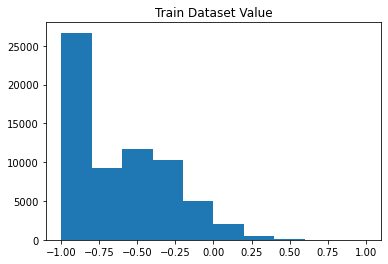

In [6]:
data = []
for i in range(len(trainds)):
    data += list((trainds[i][1].flatten().detach().cpu().numpy()))
plt.title("Train Dataset Value")
plt.hist(data)
plt.show()

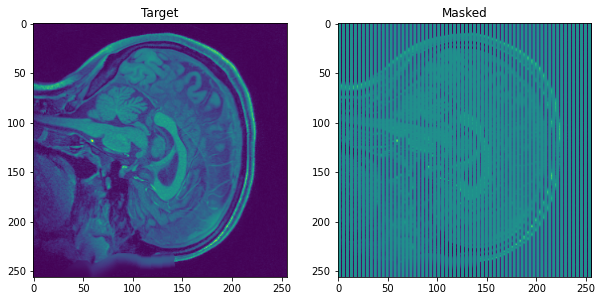

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
tgt = axs[0].imshow(ds[0][1].permute(1,2,0), vmin=-1, vmax=1)
axs[0].set_title("Target")
msk = axs[1].imshow(ds[0][0].permute(1,2,0), vmin=-1, vmax=1)
axs[1].set_title("Masked")
plt.show()


# Model 

In [126]:
def make_model(nc=64, parallel=True):
    set_seed(42)
    channels = (16, 32, 64)#, 128, 256)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=1,
    act="mish")
    model = nn.DataParallel(model) if parallel else model
    return model.to(device)
print(make_model())

DataParallel(
  (module): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
        )
        (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequential(
          (0): ResidualUnit(
            (conv): Sequential(
              (unit0): Convolution(
                (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (adn): ADN(
                  (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                  (D): Dropout(p=0.0, inplace=False)
   

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Train and Validate Functions

In [114]:
def train(model, train_loader, optimizer, criterion, device="cpu", swap=False):
    """ Trains one epoch, validates with MSE """
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        # recon = torch.tanh(model(X))
        recon = scale2range(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)

        try:
            if swap:
                criterion.filters = -criterion.filters
        except:
            pass
        mse = nn.MSELoss(reduction="mean")(recon, target)

        # Backprop and optim step
        loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates model with criterion and MSE"""
    model.eval()

    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

In [121]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    all_train_losses, all_valid_losses, all_train_mse, all_valid_mse = [], [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            # swap = True if epoch == 60 else False
            train_loss, train_mse = train(model, train_loader, optimizer, loss, device)
            valid_loss, valid_mse = validate(model, valid_loader, loss, device)
            
            all_train_losses.append(train_loss.item())
            all_train_mse.append(train_mse.item())
            all_valid_losses.append(valid_loss.item())
            all_valid_mse.append(valid_mse.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "train_loss": train_loss.item(), "train_mse":train_mse.item(), "valid_loss": valid_loss.item(), "valid_mse":valid_mse.item()}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 10))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(all_train_losses, label="train")
                axs[0].plot(all_valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(all_train_mse, label="train")
                axs[1].plot(all_valid_mse, label="valid")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE")

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx])#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy())#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx])#, vmin=X.min(), vmax=X.max())
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                loss_list = [str(l) for l in loss.losses]
                                awloss = loss.losses[loss_list.index("AWLoss()")]
                                v, T = awloss.filters[0], awloss.T
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()

In [122]:
def spectra(*data):
    fig = plt.figure(figsize=(10,6))

    for i, d in enumerate(data):
        N = len(d.flatten())

        df = fft(d.flatten().detach().cpu().numpy())
        
        plt.plot(2.0/N * np.abs(df[:10000]), label="data%g"%i)

    plt.legend()
    plt.grid()
    plt.show()

# Train AWLoss

In [123]:
# Set training static parameters and hyperparameters
nepochs=50                      
learning_rate=1e-2
batch_size=1                                        

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = DataLoader(validds,
                        batch_size=1000,
                        shuffle=False,
                        num_workers=4)


# Sample for visualisation
x_sample, y_sample = validds[0]


# Visualisation frequency
log_frequency = nepochs



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.4999587833881378, 'train_mse': 0.15909618139266968, 'valid_loss': 0.4997977018356323, 'valid_mse': 0.8698962926864624}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  0 65531


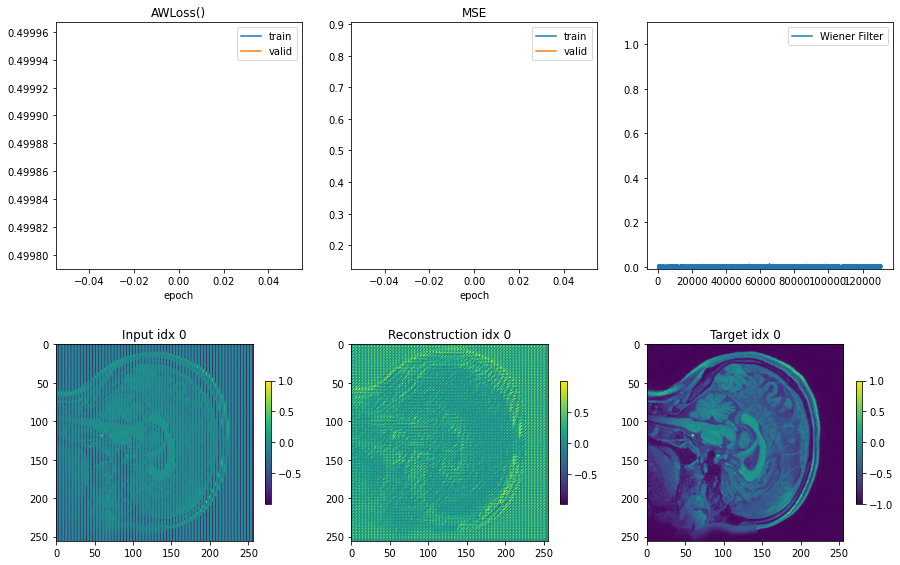

 98% (49 of 50) |####################### | Elapsed Time: 0:00:59 ETA:   0:00:01


 {'epoch': 49, 'train_loss': 0.44790220260620117, 'train_mse': 0.2700558304786682, 'valid_loss': 0.4736311435699463, 'valid_mse': 0.7947620153427124}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  0 65535


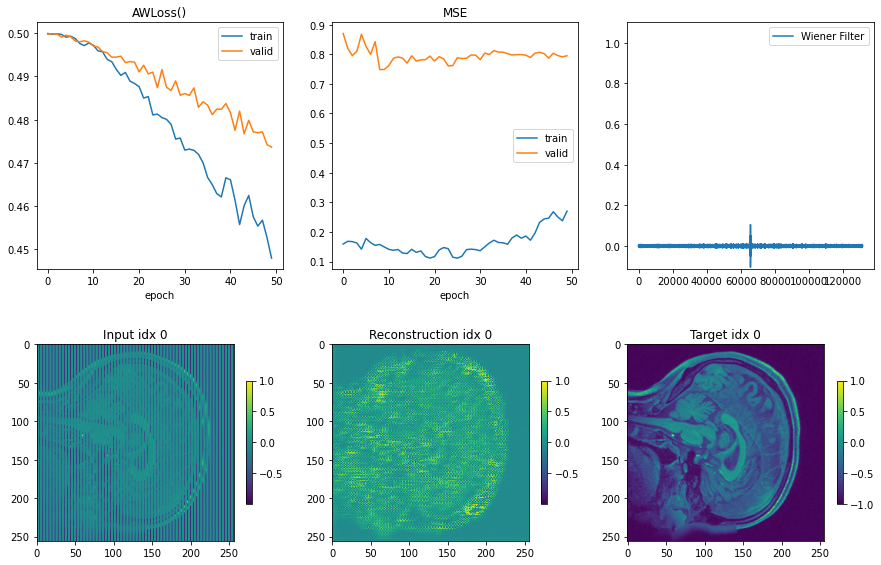

100% (50 of 50) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


In [124]:
awmodel = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(awmodel.parameters(), lr=learning_rate)
awloss     = AWLoss(filter_dim=1, std=1e-4, method="fft", reduction="mean", store_filters="norm", epsilon=3e-15)
train_model(awmodel, optimizer, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

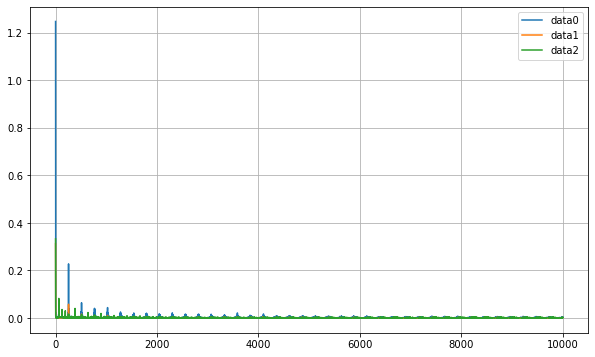

In [112]:
awmodel.eval()
X = x_sample.unsqueeze(0).to(device)
recon = torch.tanh(awmodel(X))[0]
spectra(y_sample, x_sample, recon, )



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.45506754517555237, 'train_mse': 0.8416492342948914, 'valid_loss': 0.45787450671195984, 'valid_mse': 0.8697001338005066}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  0 90276


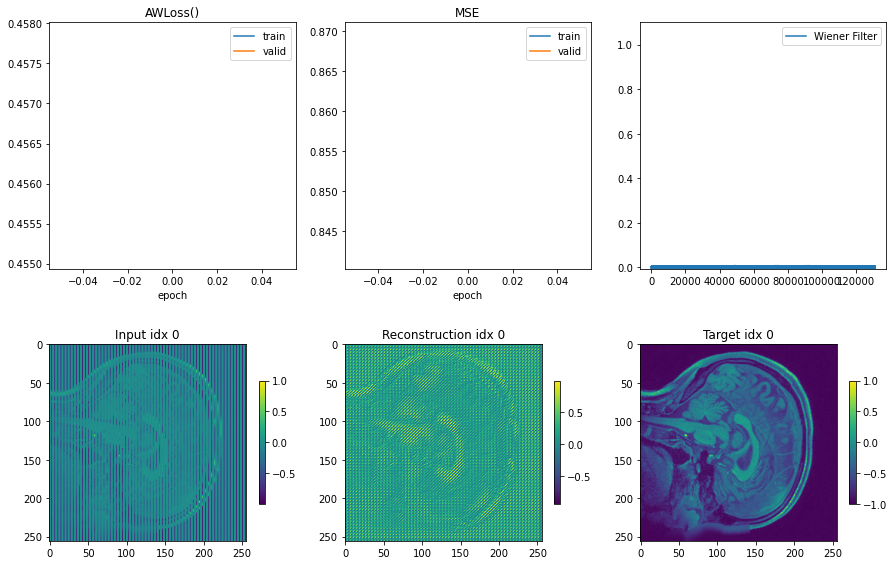

 99% (99 of 100) |###################### | Elapsed Time: 0:02:02 ETA:   0:00:01


 {'epoch': 99, 'train_loss': 0.2967715263366699, 'train_mse': 0.9597619771957397, 'valid_loss': 0.30433639883995056, 'valid_mse': 0.9640237092971802}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  0 70121


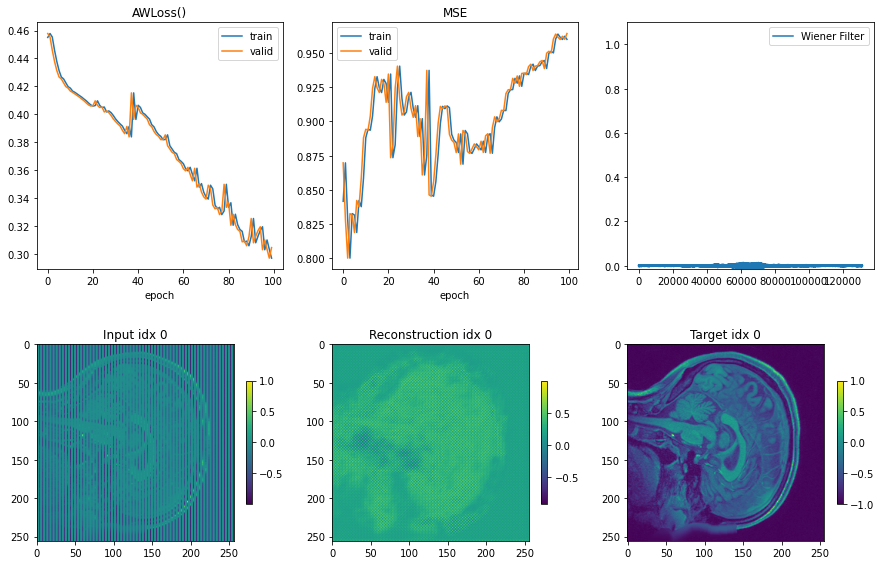

100% (100 of 100) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


In [97]:
awmodel2 = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(awmodel2.parameters(), lr=learning_rate)
awloss2     = AWLoss(filter_dim=1, std=1e-1, method="fft", reduction="mean", store_filters="norm", epsilon=3e-15)
train_model(awmodel2, optimizer, awloss2, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

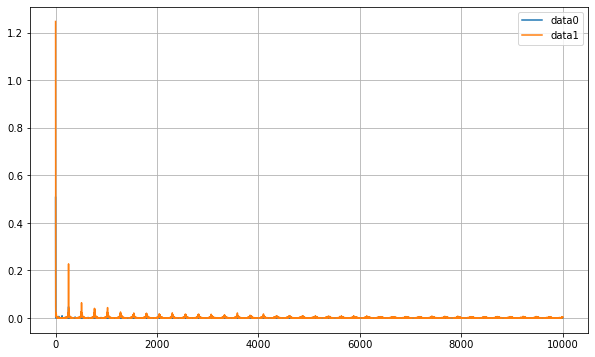

In [110]:
awmodel2.eval()
X = x_sample.unsqueeze(0).to(device)
recon2 = torch.tanh(awmodel2(X))[0]
spectra(recon2, )

Angle between x_dir and y_dir: 90.34 °


100% (2500 of 2500) |####################| Elapsed Time: 0:23:41 Time:  0:23:41


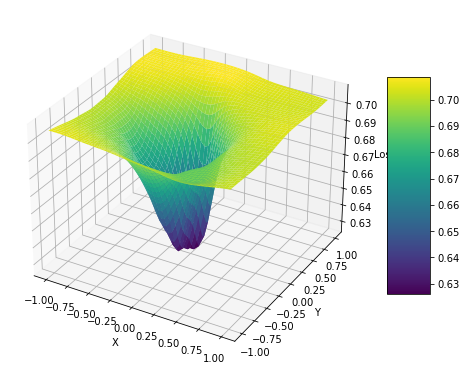

In [23]:
xx, yy, loss_landscape = visualise_landscape(awmodel, train_loader, awloss, device=device, xmin=-1, xmax=1, ymin=-1, ymax=1, nx=50, ny=50)